<a href="https://colab.research.google.com/github/javmencia/RelativeBelief/blob/BiasCalculations/RegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

USING BETAS FROM 365

In [ ]:
import numpy as np
import pymc as pm
import arviz as az



# COV = sigma^2 x Identity
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 50  # Number of observations
p = 2   # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
true_beta = np.array([1, 2])
true_sigma = 1

# Generate response variable y
y = np.dot(X, true_beta) + np.random.normal(0, true_sigma, n)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihoods
    mu = pm.math.dot(X, beta)
    y_ = pm.MvNormal('y_', mu=mu, cov = sigma * np.eye(n), shape = p)

    # Prior
    prior_beta = pm.Deterministic("prior_prior_pd", pm.logp(pm.Normal.dist(mu=mu_prior_mean, sigma=mu_prior_sigma, shape=p), beta))

    # Posterior
    # Calculate posterior mean and covariance for beta
    X_transpose = X.T
    Sigma_inv = np.eye(n) / true_sigma**2  # Assuming true_sigma for illustration
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)))
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)))
    posterior_beta = pm.Deterministic("posterior_beta", pm.logp(pm.MvNormal.dist(mu=mean_beta_post, cov=cov_beta_post, shape=p), beta))


    # Log BR
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_beta - prior_beta)

    # Likelihood
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(y_, mu, sigma).sum())

    # Sampling
    idata = pm.sample(draws=1000, tune=1000)

# Analyze the results
# az.summary(idata)


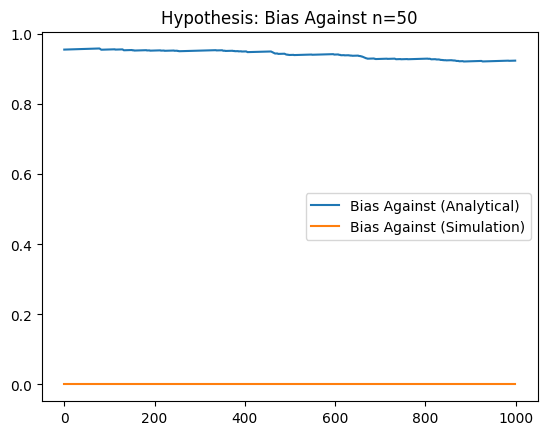

In [ ]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logBR_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['x_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

In [1]:
import numpy as np
import pymc as pm
import arviz as az



# COV = sigma^2 x Identity
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 50  # Number of observations
p = 2   # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
true_beta = np.array([1, 2])
true_sigma = 1

# Generate response variable y
y = np.dot(X, true_beta) + np.random.normal(0, true_sigma, n)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihoods
    mu = pm.math.dot(X, beta)
    y_ = pm.MvNormal('y_', mu=mu, cov = sigma * np.eye(n), shape = p)

    # Prior
    prior_beta = pm.Deterministic("prior_prior_pd", pm.logp(pm.Normal.dist(mu=mu_prior_mean, sigma=mu_prior_sigma, shape=p), beta))

    # Posterior
    # Calculate posterior mean and covariance for beta
    X_transpose = X.T
    Sigma_inv = np.eye(n) / true_sigma**2
    Sigma_beta_inv = np.eye(p) / sigma_prior_sigma**2
    print(Sigma_beta_inv.shape)
    print(np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X))).shape)

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X))) #+ Sigma_beta_inv
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)) )# + Sigma_beta_inv * true_beta)
    posterior_beta = pm.Deterministic("posterior_beta", pm.logp(pm.MvNormal.dist(mu=mean_beta_post, cov=cov_beta_post, shape=p), beta))


    # Log BR
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_beta - prior_beta)

    # Likelihood
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(y_, mu, sigma).sum())

    # Sampling
    idata = pm.sample(draws=1000, tune=1000)

# Analyze the results
# az.summary(idata)


(2, 2)
(2, 2)


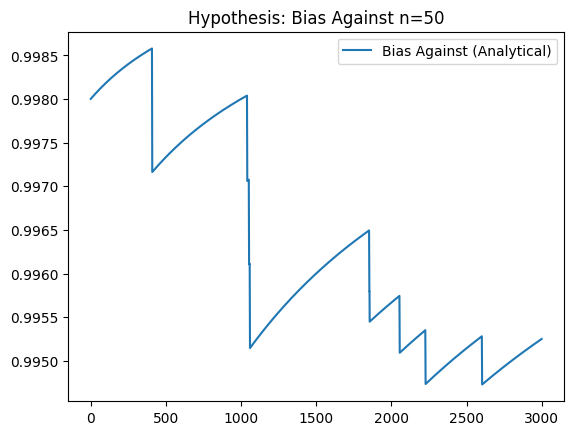

In [4]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
#plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

On y

In [2]:
import numpy as np
import pymc as pm
import arviz as az



# COV = sigma^2 x Identity
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 50  # Number of observations
p = 2   # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
true_beta = np.array([1, 2])
true_sigma = 1

# Generate response variable y
y = np.dot(X, true_beta) + np.random.normal(0, true_sigma, n)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,1))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihoods
    mu = pm.math.dot(X, beta)
    y_ = pm.Normal('y_', mu=mu, sigma = sigma)

    # Prior
    prior_beta = pm.Deterministic("prior_prior_pd", pm.logp(pm.Normal.dist(mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p, 1)), beta))
    #prior_y = pm.Deterministic("prior_y", pm.logp(pm.Normal.dist(mu = pm.math.dot(X, prior_beta), sigma = true_sigma), y_))

    # Posterior
    # Calculate posterior mean and covariance for beta
    X_transpose = X.T
    Sigma_inv = np.eye(n) / true_sigma**2
    Sigma_beta_inv = np.eye(p) / sigma_prior_sigma**2
    print(Sigma_beta_inv.shape)
    print(np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X))).shape)

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X))) #+ Sigma_beta_inv
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)) )# + Sigma_beta_inv * true_beta)
    posterior_beta = pm.Deterministic("posterior_beta", pm.logp(pm.MvNormal.dist(mu=mean_beta_post, cov=cov_beta_post, shape= (p, 1)), beta))

    #posterior_y = pm.Deterministic("posterior_y", pm.logp(pm.Normal.dist(mu=posterior_beta, sigma = sigma), y_))



    # Log BR
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_beta - prior_beta)
    logRB_prior_pdy = pm.Deterministic("logRB_prior_pdy", posterior_y - y_)

    # Likelihood
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(y_, mu, sigma).sum())

    # Sampling
    idata = pm.sample(draws=1000, tune=1000)

# Analyze the results
# az.summary(idata)


(2, 2)
(2, 2)


<ipython-input-7-eeb0e686ae58>:15: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


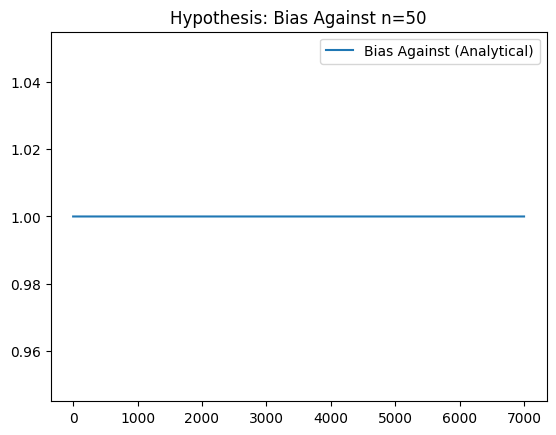

In [7]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
#plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()